# Cyclic CNN
## By Christian Koutsandreas

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os # to import models
from matplotlib.ticker import MaxNLocator # to easily set integer axis ticks

### Import pre trained models

In [23]:
# load params and training info dataframe from memory
results_df = pd.read_pickle('cnn_pre_trained.pkl')

In [24]:
# load models into list
models = []
for i, filename in enumerate(os.listdir('pre_trained_cnn')):
    models.append((keras.models.load_model('pre_trained_cnn/'+filename), i))

### add useful columns

In [25]:
# peak accuracy
results_df["peak_val_acc"] = results_df["model_history"].apply(lambda x: max(x['val_categorical_accuracy']))
# total params as well as its 
results_df['total_params'] = pd.Series(models).apply(lambda x: x[0].count_params())
# log of total params to stableize variance for more aesthetic colour map
results_df['log_total_params'] = np.log(results_df['total_params']) # might not need
# hyper params in str form
results_df['param_as_str'] = results_df.apply(lambda x: '('+str(x['filters'])+', '+str(x['num_outputs'])+')', axis=1)

### Now lets plot some data

Text(0.5, 0, 'Hyper Params')

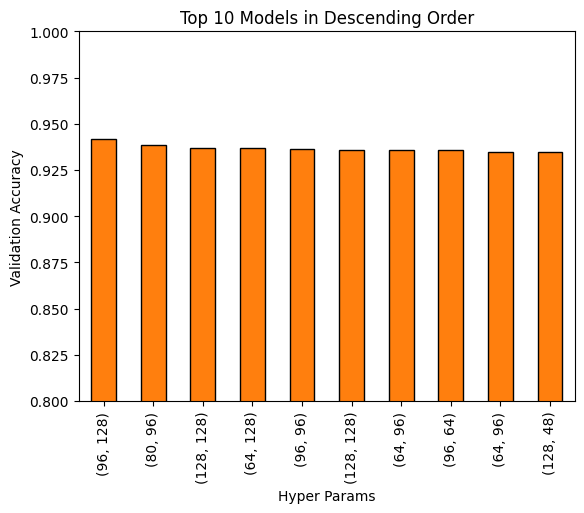

In [26]:
# lets plot the top val accuracy of top models
bars = 10 #configuration variable
results_df.sort_values(by=['peak_val_acc'], ascending = False).head(bars).plot.bar(x='param_as_str', y='peak_val_acc', color='tab:orange', legend=None, edgecolor = "black")
plt.ylim(.8,1)
plt.title('Top '+str(min(bars, results_df.shape[0]))+' Models in Descending Order')
plt.ylabel('Validation Accuracy')
plt.xlabel('Hyper Params')

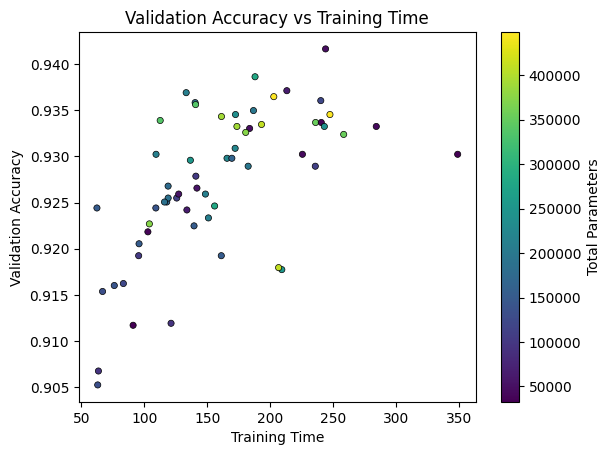

In [27]:
# lets see how training time effects accuracy
ax = results_df.plot.scatter(x='training_time', y='peak_val_acc', c='total_params', colormap='viridis', edgecolors='black', linewidths=0.5)
ax.set_title('Validation Accuracy vs Training Time')
ax.set_xlabel('Training Time')
ax.set_ylabel('Validation Accuracy')
colorbar = ax.collections[0].colorbar
colorbar.set_label('Total Parameters')

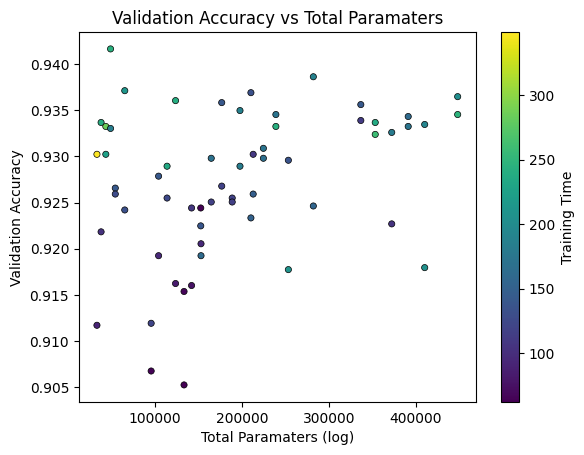

In [28]:
# lets see how training time effects accuracy
ax = results_df.plot.scatter(x='total_params', y='peak_val_acc', c='training_time', colormap='viridis', edgecolors='black', linewidths=0.5)
ax.set_title('Validation Accuracy vs Total Paramaters')
ax.set_xlabel('Total Paramaters (log)')
ax.set_ylabel('Validation Accuracy')
colorbar = ax.collections[0].colorbar
colorbar.set_label('Training Time')

#### Lets plot the best models accuracy at epochs

Text(0, 0.5, 'Accuracy')

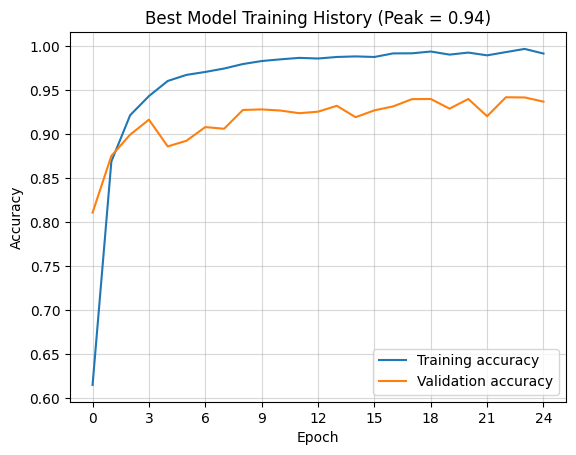

In [37]:
best_model_index = results_df['peak_val_acc'].idxmax()
best_model_hist = results_df.loc[best_model_index,'model_history']
# print(best_model_hist)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(best_model_hist['categorical_accuracy'], label='Training accuracy')
ax.plot(best_model_hist['val_categorical_accuracy'], label='Validation accuracy')
ax.legend()
ax.grid(alpha = .5)
ax.set_title("Best Model Training History (Peak = "+format(max(best_model_hist['val_categorical_accuracy']), '.2f')+')')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")


#### Lets produce a mugshot of commonly mis-classified samples

In [30]:
# Load images and labels
X = np.loadtxt('./archive/dataX.csv', delimiter=",")
y = np.genfromtxt('./archive/datay.csv', dtype="str", encoding="utf-8")

In [31]:
chars, counts = np.unique(y, return_counts=True)
# Map chars to ints in [0,num_chars] 
mapping_dict = dict(zip(chars, [x for x in range(chars.size)]))
mapping_dict_backwards = dict(zip([x for x in range(chars.size)], chars)) #may be needed later

y = np.vectorize(mapping_dict.get)(y)
# y = tf.keras.utils.to_categorical(y).astype("uint8")
X = X/255
X = X.reshape(X.shape[0], 28, 28, 1)

In [32]:
#array to store missclassifications per sample
mis_classified_counts = np.zeros(y.shape[0], dtype=int)

# run samples through all the pretrained models
# and maintain count of mis-classifications
for model in models:
    predictions = model[0].predict(X, use_multiprocessing=True, verbose=0).argmax(axis = 1)
    mis_classified_counts += predictions != y

KeyboardInterrupt: 

In [ ]:
mis_classified_indices = mis_classified_counts.argsort()
X = X[mis_classified_indices]
y = y[mis_classified_indices]
mis_classified_counts = mis_classified_counts[mis_classified_indices]

Text(0.5, 1.04, 'Commonly mis-classified characters\n(with number of times mis-classified by models)')

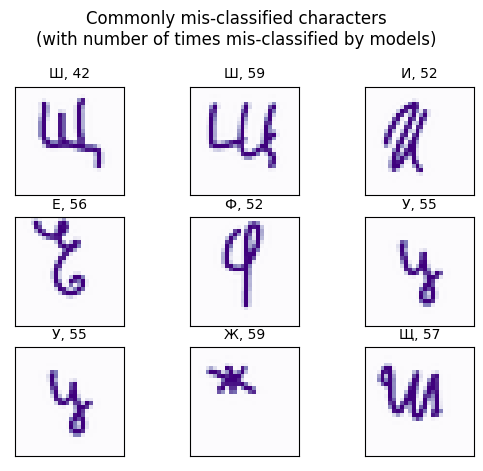

In [ ]:
# didnt want simply the most misclassifed as resulted in many duplicates
random_indices =  y.shape[0]- 1 - np.rint(np.random.exponential(scale=20, size=9)).astype('int')

fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(X[random_indices[j+i*3]].reshape(28,28), cmap='Purples')
        axs[i,j].set_title(mapping_dict_backwards[y[random_indices[j+i*3]]]+', '+str(mis_classified_counts[random_indices[j+i*3]]), fontsize=10)
        axs[i,j].axes.get_xaxis().set_visible(False)
        axs[i,j].axes.get_yaxis().set_visible(False)

# plt.suptitle('')
# plt.title("\nyoyo", fontsize=10)
# fig.title("Label and the number of models\nthat misclassified", fontsize=14, x=.5, y=.97)

plt.suptitle("Commonly mis-classified characters\n(with number of times mis-classified by models)", y=1.04)

(0.0, 1500.0)

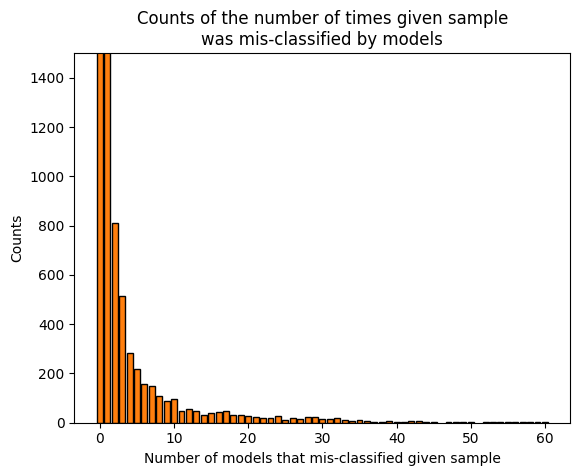

In [ ]:
bar_lables, bar_height = np.unique(mis_classified_counts, return_counts=True)
plt.bar(x=bar_lables, height=bar_height, color="tab:orange", edgecolor = "black")
plt.title("Counts of the number of times given sample\nwas mis-classified by models")
plt.ylabel("Counts")
plt.xlabel("Number of models that mis-classified given sample")
plt.ylim(0,1500) # would love to add y axis break to better display

This plot all in all shows the effectivness of CNN's as very few samples have been classified by all the models